# Evaluation Result of the Cantonese Lip Reading Model
In this Jypyter Notebook, the performance of the proposed Cantonese Lip Reading Model will be evaluated. The evaluation metrics used in this project are Character Error Rate (CER) and Word Error Rate (WER).

## Evaluation Metrics

### Character Error Rate (CER)

CER evaluates errors at the character level, which makes it particularly relevant for languages like Chinese where words are not explicitly separated by spaces. It can be calculated using the following formula:

$$
CER = \frac{I + D + S}{N}
$$

where \( I \) represents insertions, \( D \) represents deletions, \( S \) represents substitutions, and \( N \) is the total number of characters in the ground truth text.

#### Example of CER Calculation

Consider an example where the model takes a Cantonese news clip as input and predicts the spoken content based on lip movements. The ground truth (reference text) and predicted output are as follows:

| **Ground Truth** | 香港政府宣布新的防疫措施 |
|------------------|--------------------------|
| **Predicted Output** | 香港政府選簿新的防疫措施 |

*Table: Example Sentence for CER evaluation*

In the table above, the ground truth contains 12 characters, while the prediction wrongly replaces “宣布” with “選簿”. There are two incorrect characters (\( S = 2 \)) with no insertions or deletions (\( I = 0, D = 0 \)). The CER is computed as:

$$
CER = \frac{2}{12} \approx 0.1667 \quad (16.67\%)
$$

This 16.67% CER indicates that approximately one in six characters is misrecognized.

### Word Error Rate (WER)

WER measures the proportion of incorrectly transcribed words, which can be calculated using the following formula:

$$
WER = \frac{I + D + S}{N}
$$

where \( I \) represents insertions, \( D \) represents deletions, \( S \) represents substitutions, and \( N \) is the total number of words in the ground truth text.

#### Example of WER Calculation

Consider an example where the model takes a Cantonese news clip as input and predicts the spoken content based on lip movements. The ground truth (reference text) and predicted output are as follows:

| **Ground Truth** | 香港政府宣布新的防疫措施 |
|------------------|--------------------------|
| **Predicted Output** | 香港政府選簿新的防疫措施 |

*Table: Example Sentence for WER evaluation*

In this example, the sentence consists of 5 words: 香港 / 政府 / 宣布 / 新的 / 防疫措施. The prediction incorrectly transcribes “宣布” as “選簿”, which is counted as one substitution (\( S = 1 \)). Since there are no insertions or deletions (\( I = 0, D = 0 \)), the WER is calculated as:

$$
WER = \frac{1}{5} = 0.2 \quad (20\%)
$$

A WER of 20% means that one out of every five words is transcribed incorrectly.

## Model Performance Evaluation

A helper function `eval_err()` is defined to calculate the Error Rate of the Prediction by the Model.

In [6]:
import pandas as pd
from torchmetrics.text import CharErrorRate
from torchmetrics.text import WordErrorRate
from tqdm import tqdm

def eval_err(csv_file_path, col1="predicted_cantonese", col2="transcript_trad", method="cer"):
    df = pd.read_csv(csv_file_path)
    
    # Handle NaN column by setting it to be Empty String
    df[col1] = df[col1].fillna("").str.upper()
    df[col2] = df[col2].fillna("").str.upper()
    
    # Select Character Error Rate (CER) / Word Error Rate (WER) according to the method specified.
    if method == "cer":
        err = CharErrorRate()
    elif method == "wer":
        err = WordErrorRate()
    
    # Calculate the CER/WER on every row
    cer_scores = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        pred = row[col1]  # Predicted Column
        truth = row[col2]  # Ground Truth Column
        cer_score = err(pred, truth)
        cer_scores.append(cer_score.item())
    
    
    df['cer_score'] = cer_scores
    df.to_csv(f'../cer/{csv_file_path}', index=False)

    # Returning Average CER/WER
    return df['cer_score'].mean()


In [10]:
%config InlineBackend.figure_format = 'retina'


## Comparing Ambiguous to Absolute Jyutping Prediction


| **Original Initials**                 | **Mapped Initial** |
|--------------------------------------|--------------------|
| b, p, m                              | b                  |
| d, t, z, c, s, j, n, ng, g, k        | d                  |
| gw, kw, w                            | w                  |

<center>Table: Mapping of Jyutping initials to merged categories for fuzzy initial modeling</center>


As shown in the table above, a fuzzy Jyutping initial modeling approach was proposed, where multiple initials with visually similar lip shapes were mapped together. This strategy aims to address difficulties encountered by the VSR model in distinguishing among these similar initials, with the expectation that the LLM could better differentiate them using contextual information.


### Testing

In [12]:
eval_err("result_icable_76_epoch_test_absolute_full.csv")

7590it [00:06, 1164.17it/s]


np.float64(0.49801913475585863)

In [15]:
eval_err("result_icable_76_epoch_test_ambiguous_full.csv")

7589it [00:06, 1219.58it/s]


np.float64(0.6902327346638196)

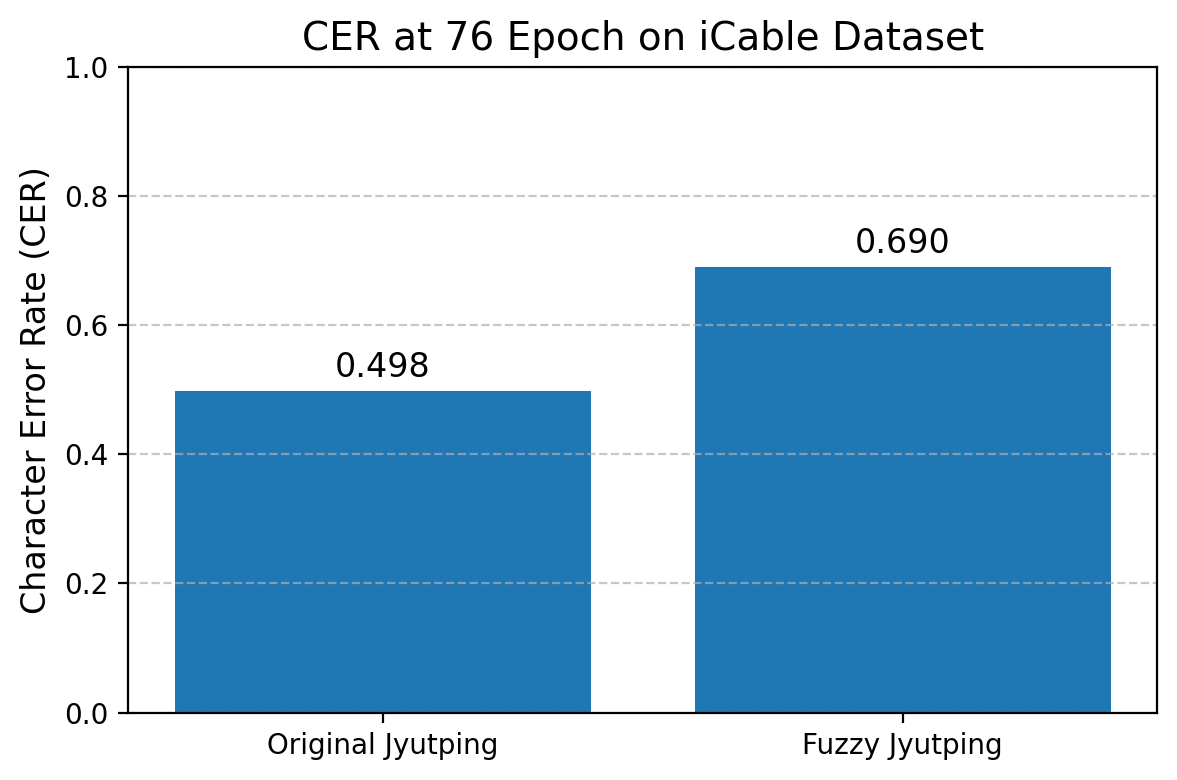

In [59]:
import matplotlib.pyplot as plt

# Data
epochs = [76, 76]
cer_values = [0.49801913575585863, 0.6902327346638196]
labels = ['Original Jyutping', 'Fuzzy Jyutping']

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, cer_values)

# Annotate bars with CER values
for bar, cer in zip(bars, cer_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{cer:.3f}', ha='center', va='bottom', fontsize=12)

plt.title('CER at 76 Epoch on iCable Dataset', fontsize=14)
plt.ylabel('Character Error Rate (CER)', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


It was observed that after adopting the fuzzy (ambiguous) Jyutping approach, the Character Error Rate (CER) dropped significantly from 0.49 to 0.69. This result suggests that the language model is not yet sufficiently capable of handling a large number of ambiguous syllables, which may be attributed to the relatively limited capacity of the model fine-tuned using Low-Rank Adaptation (LoRA). As a result, the model shows a deterioration in performance compared to absolute Jyutping representations, as illustrated in the figure. Future work should investigate the application of larger-scale models or alternative fine-tuning strategies that are better suited to disambiguating Jyutping-to-Cantonese mappings.

# Comparison of Random Training versus Training from an English VSR Pretrained Model

This section compares the performance of two training strategies: **training a model from scratch** versus **initializing it with a pretrained English Visual Speech Recognition (VSR) model**, where both the encoder and the frontend components are transferred. The underlying assumption is that the frontend and encoder modules capture more general, language-agnostic features, which are less tied to specific linguistic characteristics. As a result, transferring these components from a pretrained English VSR model is expected to benefit the training process.

To test this hypothesis, we trained two models for Cantonese lip reading: one with the frontend and encoder transferred from a VSR model pretrained on 3,291 hours of English speech data, and another initialized entirely from scratch without any pretrained components. Then, whether this transfer of knowledge could improve the performance of the Cantonese lip reading model is evaluated.

## Without Pretrained Model

In [53]:
eval_err("(without_pretrained_model) result_tvb_29_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:22<00:00, 1355.71it/s]


np.float64(0.2504419558919787)

In [52]:
eval_err("(without_pretrained_model) result_tvb_29_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:18<00:00, 1619.86it/s]


np.float64(0.1003461212523406)

## With English Pretrained Model

In [54]:
eval_err("(with_pretrained_model) result_tvb_29_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:24<00:00, 1227.29it/s]


np.float64(0.27564881501652017)

In [55]:
eval_err("(with_pretrained_model) result_tvb_29_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:22<00:00, 1342.86it/s]


np.float64(0.12466133733823821)

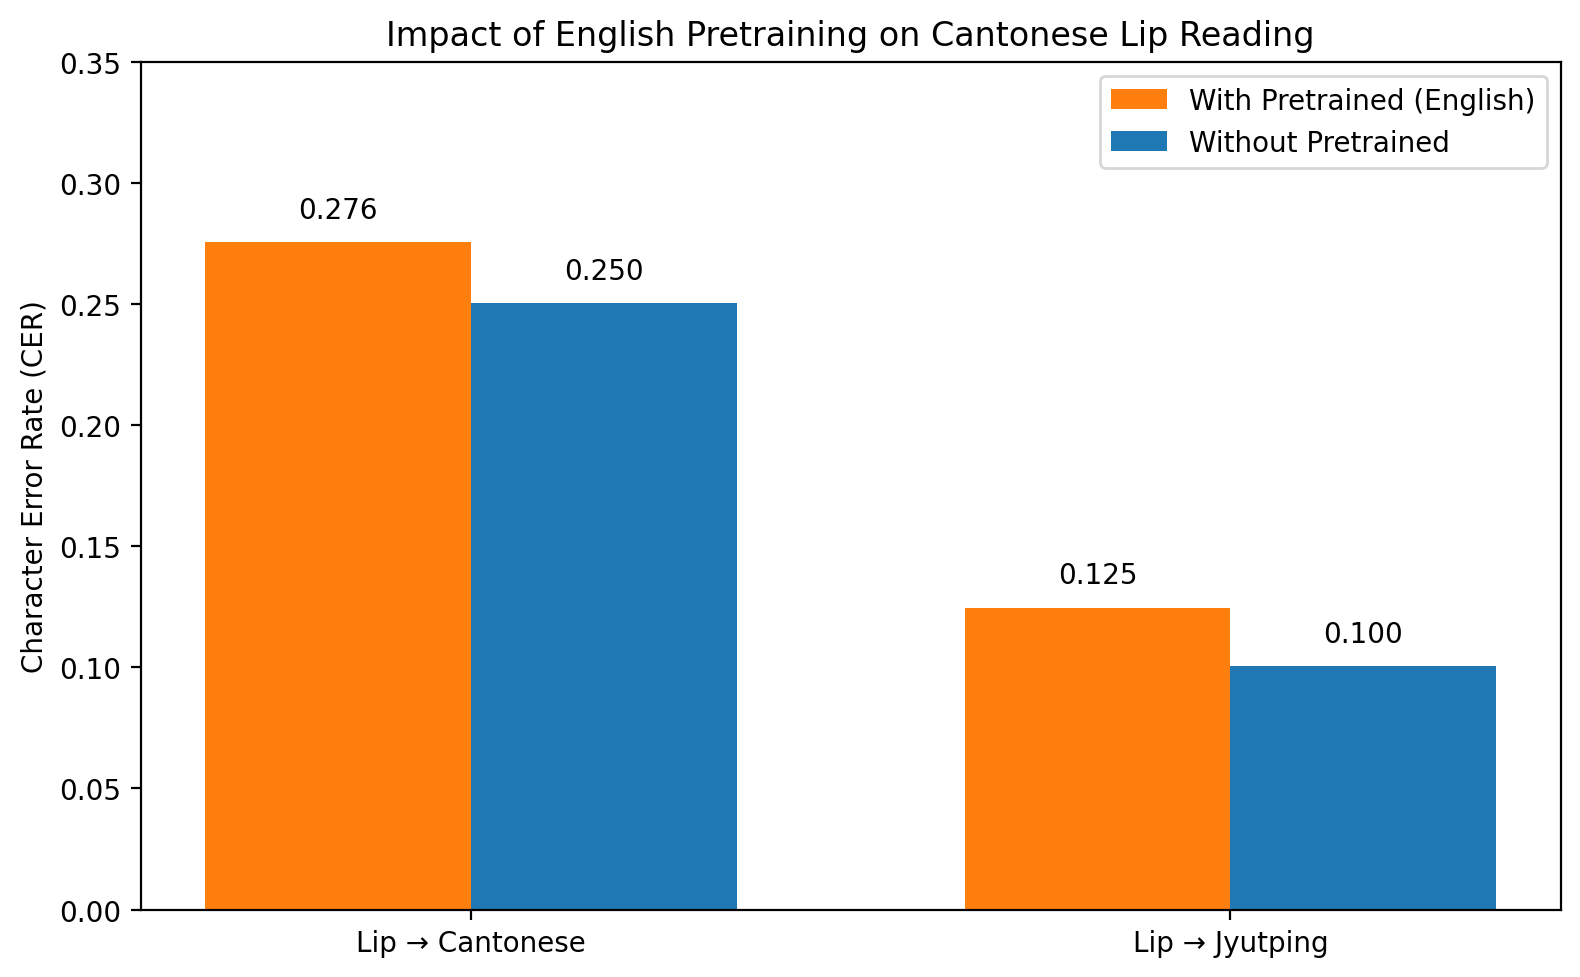

In [52]:
# Data
tasks = ['Lip → Cantonese', 'Lip → Jyutping']
cer_pretrained = [0.27564881501652017, 0.12466133733823821]
cer_no_pretrain = [0.2504419558919787, 0.1003461212523406]

x = range(len(tasks))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x, cer_pretrained, width=bar_width, label='With Pretrained (English)', color='C1')
plt.bar([i + bar_width for i in x], cer_no_pretrain, width=bar_width, label='Without Pretrained', color='C0')

# Labels & formatting
plt.ylabel('Character Error Rate (CER)')
plt.title('Impact of English Pretraining on Cantonese Lip Reading')
plt.xticks([i + bar_width / 2 for i in x], tasks)
plt.ylim(0, 0.35)
plt.legend()

# Value labels
for i in x:
    plt.text(i, cer_pretrained[i] + 0.01, f'{cer_pretrained[i]:.3f}', ha='center')
    plt.text(i + bar_width, cer_no_pretrain[i] + 0.01, f'{cer_no_pretrain[i]:.3f}', ha='center')

plt.tight_layout()
plt.show()


As shown in Figure, using a pretrained model trained on 3,291 hours of English lip reading data (including LRS2, LRS3, VoxCeleb2, and AVSpeech) resulted in a slightly higher Character Error Rate compared to training from scratch at the same number of epoch (epoch 29). Specifically, for the Lip-to-Cantonese task, the CER increased from 25\% to 27.6\%, and for Lip-to-Jyutping, it increased from 10\% to 12.5\%. It suggests that transfer learning from English lip reading may not provide benefits for Cantonese. Instead, it might even harm the performance of the Cantonese Lip Reading Model, which might potentially due to phonetic and visual mismatches between the two languages.

# Performance on Unseen Speaker vs Seen Speakers

Different from the previous studies that trained on the entire dataset, our model was first trained solely on the TVB dataset. This experimental design enables an evaluation of the model’s ability to generalize to unseen speakers in the i-Cable dataset. The results are shown below.

In [63]:
eval_err("result_tvb_35_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:24<00:00, 1266.83it/s]


np.float64(0.26570772265755777)

In [62]:
eval_err("result_icable_35_epoch_test_absolute_full.csv")

100%|██████████| 7590/7590 [00:07<00:00, 1058.70it/s]


np.float64(1.1587188924411227)

In [53]:
eval_err("result_tvb_75_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:21<00:00, 1411.21it/s]


np.float64(0.2351751016388851)

In [54]:
eval_err("result_icable_75_epoch_test_absolute_full.csv")

100%|██████████| 7590/7590 [00:07<00:00, 1070.83it/s]


np.float64(1.183584447797972)

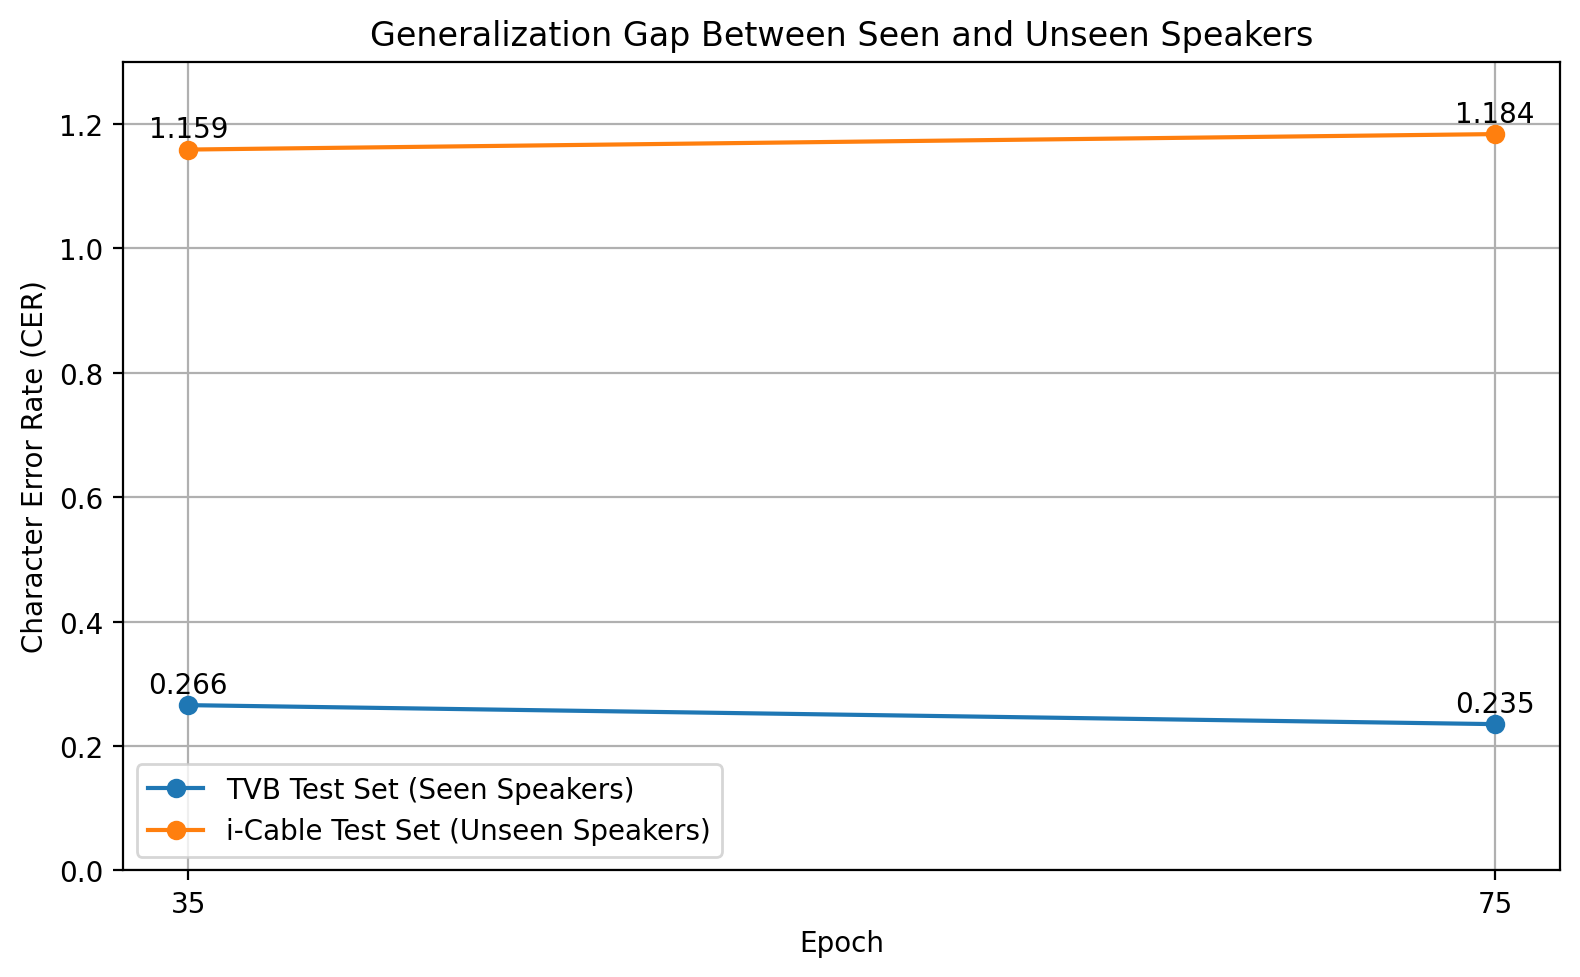

In [55]:
# Data
epochs = [35, 75]
cer_tvb = [0.26570772265755777, 0.2351751016388851]
cer_icable = [1.1587188924411227, 1.183584447797972]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, cer_tvb, marker='o', label='TVB Test Set (Seen Speakers)')
plt.plot(epochs, cer_icable, marker='o', label='i-Cable Test Set (Unseen Speakers)')
plt.xlabel('Epoch')
plt.ylabel('Character Error Rate (CER)')
plt.title('Generalization Gap Between Seen and Unseen Speakers')
plt.ylim(0, 1.3)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Value labels
for i in range(len(epochs)):
    plt.text(epochs[i], cer_tvb[i] + 0.02, f'{cer_tvb[i]:.3f}', ha='center')
    plt.text(epochs[i], cer_icable[i] + 0.02, f'{cer_icable[i]:.3f}', ha='center')

plt.tight_layout()
plt.show()


As illustrated in Figure, the model demonstrates strong performance on the TVB test set, where the speakers were seen during training. However, its performance on the i-Cable test set, which contains unseen speakers, is significantly worse. The CER increased from 1.159 at epoch 35 to 1.184 at epoch 75. Although it might suggests that the model overfits to the training set, it is more likely that the model has not seen enough speakers that allows it to generalize it performance on an unseen speaker. This result indicates the importance of having a large and diverse set of speakers in the training dataset to ensure the model generalizes well to unseen individuals. The current TVB dataset, which contains approximately 50 speakers appears insufficient for this purpose.

# Contribution of Error Across Cantonese Lip Reading Pipeline

In this section, we analyze the sources of error using the model trained for 75 epochs on the TVB dataset and 60 epochs on the i-Cable dataset. The objective is to identify which components of the lip reading model contribute most significantly to the overall error. Understanding these contributions may indicate specific stages in the pipeline that offer greater potential for future improvements.

First, the Character Error Rate (CER) between the Ground Truth Cantonese and the predicted Cantonese using Ground Truth Jyutping is calculated.

In [41]:
eval_err("result_tvb_75_epoch_test_absolute_full.csv", "gt_predicted_cantonese", "transcript_trad")

100%|██████████| 30648/30648 [00:24<00:00, 1250.94it/s]


np.float64(0.1718935068820476)

Then, the Word Error Rate (WER) between the Ground Truth Jyutping and predicted Jyutping using Mouth ROI is calculated. Since the Word Error Rate (WER) is calculated on Jyutping, it is equivalent to calculating the Character Error Rate (CER) on Chinese Words.

In [43]:
eval_err("result_tvb_75_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:24<00:00, 1230.89it/s]


np.float64(0.08169754246649454)

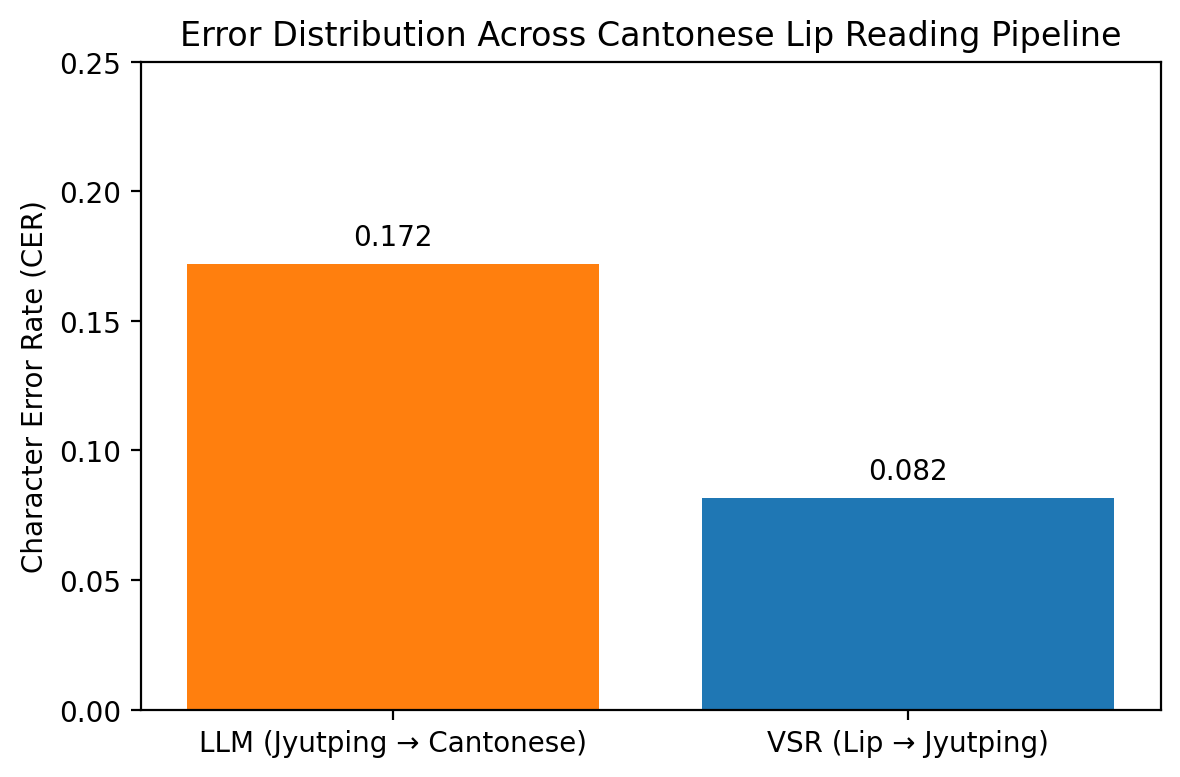

In [51]:
# Data for the plot
components = ['LLM (Jyutping → Cantonese)', 'VSR (Lip → Jyutping)']
cer = [0.1718935068820476, 0.08169754246649454]

# Colors: highlight LLM stage
colors = ['C1', 'C0']

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(components, cer, color=colors)
plt.ylabel('Character Error Rate (CER)')
plt.title('Error Distribution Across Cantonese Lip Reading Pipeline')
plt.ylim(0, 0.25)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


As shown in Figure, the majority of prediction errors in the Cantonese lip reading pipeline originate from the Jyutping-to-Cantonese stage powered by the Large Language Model (LLM), which has a CER of 17.2\%. In contrast, the visual speech recognition (Lip-to-Jyutping) model achieves a significantly lower CER of 8.2\% only. This result suggests the fact that, for seen speakers, the Jyutping-to-Cantonese step contributes more heavily to the overall character-level error.

# Accuracy trend of the Lip Reading Model along with the model training

In the following, the Character Error Rate (CER) on the TVB test set will be evaluated on different epochs and settings.

## Mouth-to-Cantonese Prediction

In [54]:
eval_err("result_tvb_29_2_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:24<00:00, 1227.29it/s]


np.float64(0.27564881501652017)

In [46]:
eval_err("result_tvb_35_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:24<00:00, 1226.34it/s]


np.float64(0.26570772265755777)

In [16]:
eval_err("result_tvb_75_epoch_test_absolute_full.csv")

30648it [00:20, 1496.05it/s]


np.float64(0.23542194898970545)

In [49]:
eval_err("result_tvb_135_epoch_test_absolute_full.csv")

100%|██████████| 30648/30648 [00:20<00:00, 1497.49it/s]


np.float64(0.2195011784593132)

## Mouth-to-Jyutping Prediction

In [55]:
eval_err("result_tvb_29_2_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:22<00:00, 1342.86it/s]


np.float64(0.12466133733823821)

In [47]:
eval_err("result_tvb_35_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:24<00:00, 1234.48it/s]


np.float64(0.11580288475678363)

In [48]:
eval_err("result_tvb_75_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:23<00:00, 1287.17it/s]


np.float64(0.08169754246649454)

In [50]:
eval_err("result_tvb_135_epoch_test_absolute_full.csv", "prediction", "ground_truth", "wer")

100%|██████████| 30648/30648 [00:27<00:00, 1127.05it/s]


np.float64(0.06703127014186477)

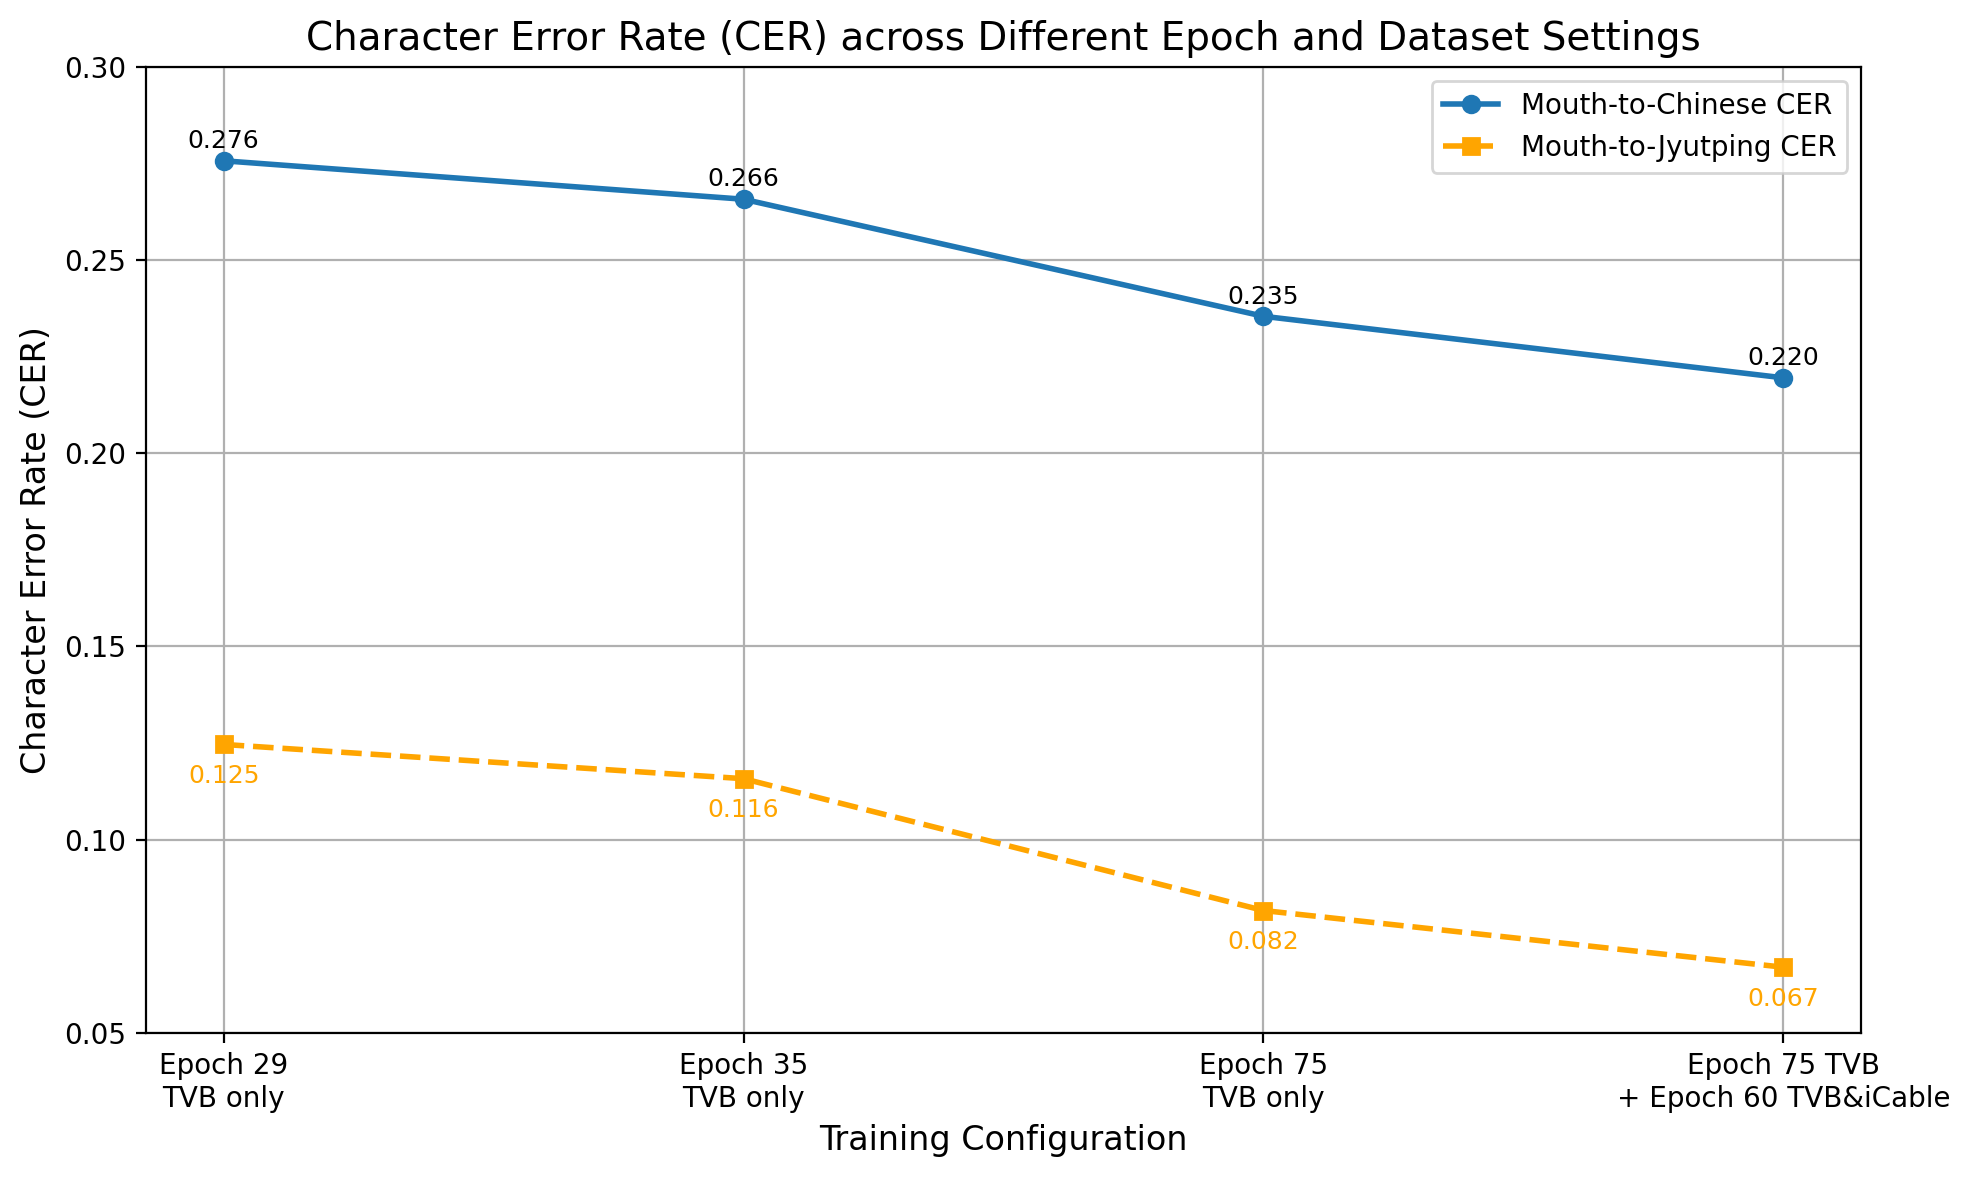

In [11]:
import matplotlib.pyplot as plt

# Data
labels = [
    "Epoch 29\nTVB only",
    "Epoch 35\nTVB only",
    "Epoch 75\nTVB only",
    "Epoch 75 TVB\n+ Epoch 60 TVB&iCable"
]
cer_values_mouth_to_chinese = [0.27564881501652017, 0.26570772265755777, 0.23542194898970545, 0.2195011784593132]
cer_values_mouth_to_jyutping = [0.12466133733823821, 0.11580288475678363, 0.08169754246649454, 0.06703127014186477]

# Plotting
plt.figure(figsize=(10, 6))

# Plot Chinese CER
plt.plot(labels, cer_values_mouth_to_chinese, marker='o', linestyle='-', linewidth=2, label="Mouth-to-Chinese CER")

# Add CER values for Chinese
for i, value in enumerate(cer_values_mouth_to_chinese):
    plt.text(i, value + 0.002, f"{value:.3f}", ha='center', va='bottom', fontsize=9)

# Plot Jyutping CER
plt.plot(labels, cer_values_mouth_to_jyutping, marker='s', linestyle='--', linewidth=2, label="Mouth-to-Jyutping CER", color='orange')

# Add CER values for Jyutping
for i, value in enumerate(cer_values_mouth_to_jyutping):
    plt.text(i, value - 0.005, f"{value:.3f}", ha='center', va='top', fontsize=9, color='orange')

# Formatting
plt.title("Character Error Rate (CER) across Different Epoch and Dataset Settings", fontsize=14)
plt.xlabel("Training Configuration", fontsize=12)
plt.ylabel("Character Error Rate (CER)", fontsize=12)
plt.ylim(0.05, 0.3)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


As illustrated in Figure, the Character Error Rate (CER) decreases as the number of training epochs increases. After training the model on the TVB training set for 29 epochs, the Character Error Rate (CER) starts to drop under 30\%. When training the model on the TVB training set for 75 epochs, the CER dropped to 23.5\%. Then, the model was further trained for an additional 60 epochs using a combined training set consisting of both the TVB and i-Cable datasets, which led to a further reduction in CER to 21.9\%.

Additionally, the Mouth-to-Jyutping Character Error Rate (CER) shows a proportional drop compared to the Mouth-to-Chineses CER, which implies that although the Jyutping-to-Cantonese module will introduce error, minimizing the error introduced by the Visual Speech Recognition (VSR) model can still largely affect the accuracy of the model.

# Word Error Rate (WER) Comparison with 3D-VAN

Xiao er al. proposed the 3D-VAN model in paper [Cantonese sentence dataset for lip-reading](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/ipr2.13123), which integrates 3D convolution with a visual attention network and was trained on the Cantonese sentence-level lip-reading dataset (CLRS). Since 3D-VAN is currently the only publicly known sentence-level Cantonese lip-reading model, it serves as a reference point for a preliminary comparison with the model developed in this project.

Due to the unavailability of both the codebase and pretrained model, direct re-implementation of 3D-VAN was not feasible. As a result, a naive comparison was conducted based on the Word Error Rate (WER) reported by both models on their respective datasets. For the model in this project, the Model with 75 epochs trained on TVB dataset and 60 epochs trained on i-Cable dataset is used.

First, the model trained 75 epochs on TVB training set and 60 epochs on iCable training set is used. The performance is evaluated on the iCable test set.

In [11]:
eval_err("result_icable_135_epoch_test_absolute_full_word_segmented.csv", "predicted_cantonese_word_segmented", "transcript_trad_word_segmented", "wer")

100%|██████████| 7590/7590 [00:04<00:00, 1765.11it/s]


np.float64(0.5343071540864246)

Then, the same model is evaluated on the TVB test set.

In [8]:
eval_err("result_tvb_135_epoch_test_absolute_full_word_segmented.csv", "predicted_cantonese_word_segmented", "transcript_trad_word_segmented", "wer")

100%|██████████| 30648/30648 [00:21<00:00, 1458.80it/s]


np.float64(0.36030626529596765)

The average results considering the number of samples is calculated in the following:

In [10]:
(0.5343071540864246 * 7590 + 0.36030626529596765 * 30648) / (7590+30648)

0.39484433595655577

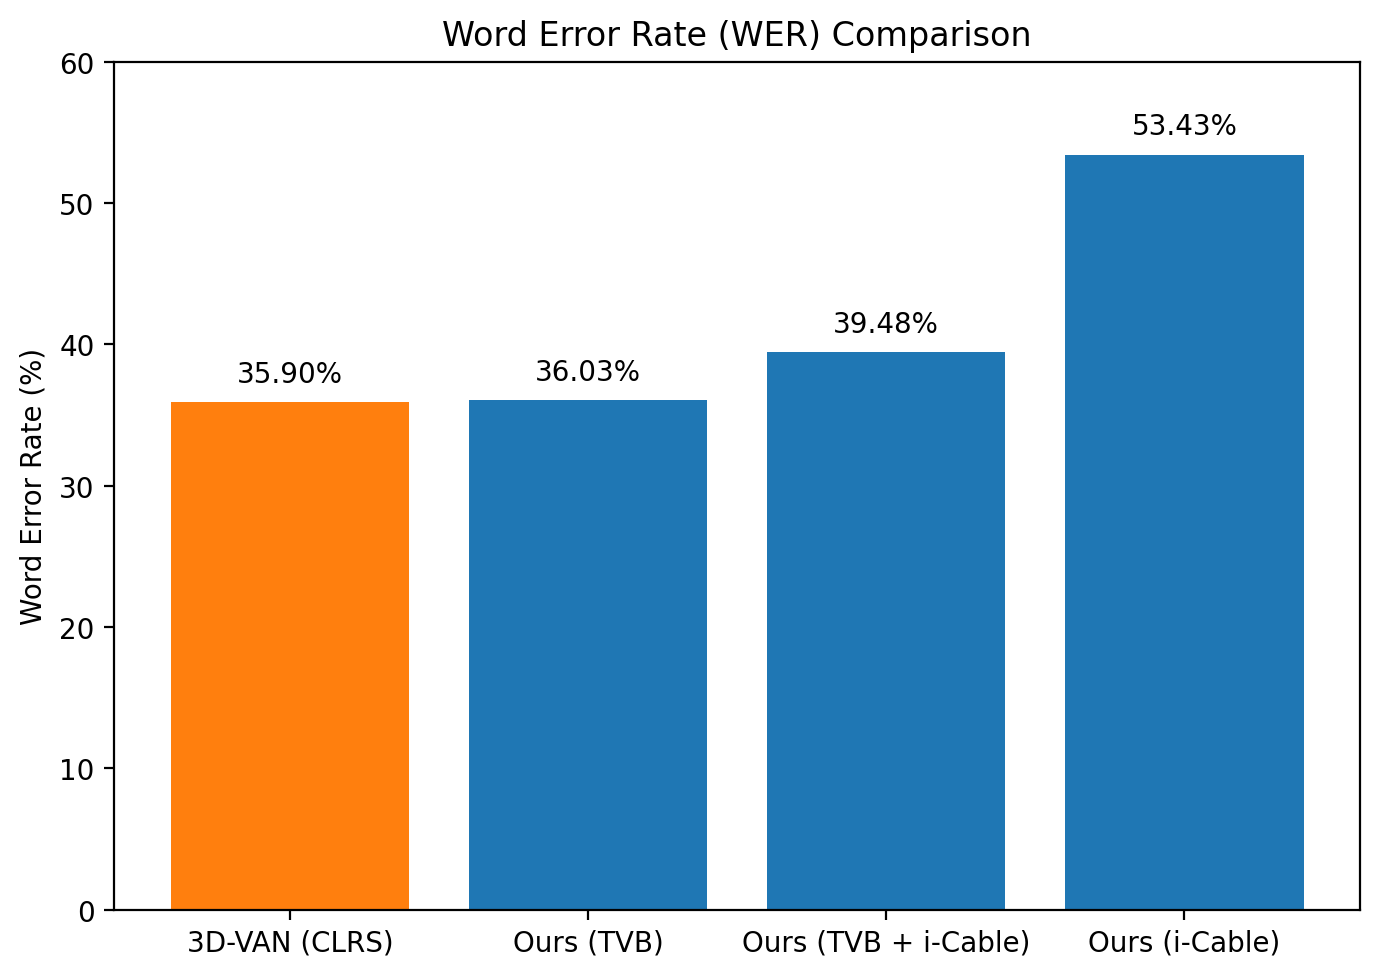

In [15]:
import matplotlib.pyplot as plt

# Data
models = ['3D-VAN (CLRS)', 'Ours (TVB)', 'Ours (TVB + i-Cable)', 'Ours (i-Cable)']
wer = [35.9, 36.03, 39.48, 53.43]
colors = ['C1', 'C0', 'C0', 'C0']  # Different color for 3D-VAN

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(models, wer, color=colors)
plt.ylabel('Word Error Rate (%)')
plt.title('Word Error Rate (WER) Comparison')
plt.ylim(0, 60)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


The Figure illustrates a comparison of Word Error Rates (WER) between 3D-VAN and our models evaluated on different datasets. While the 3D-VAN model achieved 35.9\% WER on the CLRS dataset, our model yielded comparable results with 36.03\% WER on the TVB test set and 39.48\% on the combined TVB and i-Cable test set.

A slightly worse result is on the iCable test set, where our model shows 53.43\% WER. Considering the number of hours of the iCable dataset is significantlly smaller, it might implies that the number of hours in the training data will affect the generalization performance of the model significantly.